In [45]:
from openai_api import client

from crawler import crawl, TextToCSVClass, get_shortened
import pandas as pd
import tiktoken

In [46]:
domain = "react.dev"  # <- put your domain to be crawled
full_url = "https://react.dev/learn"  # <- put your domain to be crawled with https or http

In [47]:
crawl(full_url,100)
TextToCSVClass(domain).to_csv()

https://react.dev/learn
https://react.dev/learn/choosing-the-state-structure
https://react.dev/learn/updating-objects-in-state#write-concise-update-logic-with-immer
https://react.dev/reference/react/memo
https://react.dev/reference/react-dom/components/select
https://react.dev/learn/responding-to-events#capture-phase-events
https://react.dev/reference/react-dom/components/common#common-props
https://react.dev/learn/manipulating-the-dom-with-refs#how-to-manage-a-list-of-refs-using-a-ref-callback
https://react.dev/reference/react-dom/components/common#ref-callback
https://react.dev/learn/render-and-commit#step-3-react-commits-changes-to-the-dom
https://react.dev/reference/react/useState#setstate
https://react.dev/learn/choosing-the-state-structure#avoid-redundant-state
https://react.dev/learn/referencing-values-with-refs#best-practices-for-refs
https://react.dev/reference/react/useRef#manipulating-the-dom-with-a-ref
https://react.dev/learn/manipulating-the-dom-with-refs#accessing-another

<Axes: >

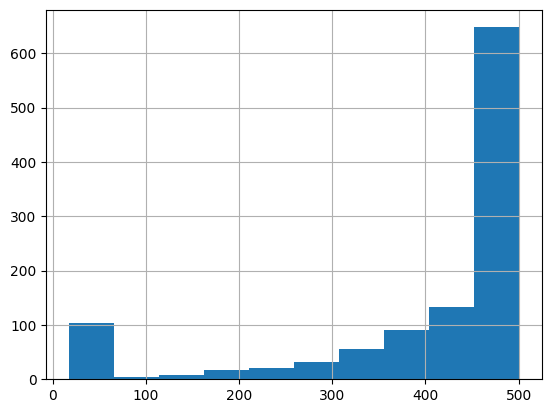

In [48]:
tokenizer = tiktoken.get_encoding("cl100k_base")
shortened = get_shortened()
df = pd.DataFrame(shortened, columns=['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [49]:
df['embeddings'] = df.text.apply(
    lambda x: client.embeddings.create(input=x, model='text-embedding-ada-002').data[0].embedding)

df.to_csv('processed/embeddings.csv')
df.to_json('./data.json')
df.head()

,text,n_tokens,embeddings
0,earn javascript in jsx with curly braces#using...,498,"[-0.002627268899232149, 0.017450597137212753, ..."
1,But what if you want to dynamically specify th...,494,"[0.004010324832051992, 0.02383051998913288, -0..."
2,"Objects are also denoted with curly braces, li...",429,"[0.014038528315722942, 0.03054654970765114, -0..."
3,"Zara"" /> <ul> <li>Improve the videophone</...",377,"[0.008310513570904732, 0.026271086186170578, -..."
4,dev learn understanding your ui as a tree#the ...,57,"[0.004456026945263147, -0.0064140306785702705,..."


In [50]:
import numpy as np
from scipy import spatial

df = pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,earn javascript in jsx with curly braces#using...,498,"[-0.002627268899232149, 0.017450597137212753, ..."
1,But what if you want to dynamically specify th...,494,"[0.004010324832051992, 0.02383051998913288, -0..."
2,"Objects are also denoted with curly braces, li...",429,"[0.014038528315722942, 0.03054654970765114, -0..."
3,"Zara"" /> <ul> <li>Improve the videophone</...",377,"[0.008310513570904732, 0.026271086186170578, -..."
4,dev learn understanding your ui as a tree#the ...,57,"[0.004456026945263147, -0.0064140306785702705,..."


In [51]:
def create_context(
    question, dataframe, max_len=1800, size="ada"
):
    q_embeddings = client.embeddings.create(input=question, model='text-embedding-ada-002').data[0].embedding
    
    df['distances'] = [[] for _ in range(len(df))]
    # Get the distances from the embeddings
    for i in range(0,len(dataframe['embeddings'])):
        dataframe['distances', i] = 1 - spatial.distance.cosine(q_embeddings, dataframe['embeddings'][i])


    returns = []
    cur_len = 0

    for i, row in dataframe.sort_values('distances', ascending=True).iterrows():

        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4

        if cur_len > max_len:
            break
            
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

In [52]:
def answer_question(
        dataframe,
        model="gpt-4",
        question="Say something interesting",
        max_len=1800,
        size="ada",
        max_tokens=150,
        stop_sequence=None
):
    context = create_context(
        question,
        dataframe,
        max_len=max_len,
        size=size,
    )
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system",
                 "content": "Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\n"},
                {"role": "user", "content": f"Context: {context}\n\n---\n\nQuestion: {question}\nAnswer:"}
            ],
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
        )
        return response.choices[0].message.content
    except Exception as e:
        print(e)
        return ""

In [53]:
answer_question(df, question="Say something about an angular")

/tmp/ipykernel_24698/153867315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe['distances', i] = 1 - spatial.distance.cosine(q_embeddings, dataframe['embeddings'][i])
/tmp/ipykernel_24698/153867315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe['distances', i] = 1 - spatial.distance.cosine(q_embeddings, dataframe['embeddings'][i])
/tmp/ipykernel_24698/153867315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

"I don't know"